<div style="text-align: center"> feature engineering  

              


In [1]:
import os
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

if parent_dir not in sys.path:
    sys.path.append(parent_dir)

import GEO_PLOT
import RESEARCH


In [2]:

import matplotlib
import matplotlib.pyplot as plt
from sklearn import datasets

import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
def plot_learning_curve(model, scr_train, scr_test, feature_names, fig_name='learning_curve.png'):
    """
    using train and test valid datasets, but the showing "testing curve"
    model:
    evalSet:
    :return:
    """

    # plotting:

    result = model.evals_result()

    plt.figure(figsize=(8, 8))

    plt.plot(result['validation_0']['rmse'], label='train=%f' % scr_train, color='blue')
    plt.plot(result['validation_1']['rmse'], label='test=%f' % scr_test, color='red')

    # Add text to the top-left of the figure
    plt.text(0.15, 0.75, f'{len(feature_names)} features: {feature_names}',
             fontsize=12, color='green', transform=plt.gca().transAxes, verticalalignment='top')

    plt.tick_params(labelsize=14)
    plt.ylabel('', fontsize=148)
    plt.xlabel('', fontsize=148)
    plt.title("Learning curve RMSE (Stepwise_Feature_Elimination)", fontsize=14)
    plt.legend(prop={'size': 15})
    plt.ylim([0.06, 0.22])
    plt.savefig(f'./{fig_name:s}')
    plt.show()


## 1. Téléchargement et visualiation des données


In [4]:
X_train, y_train, X_valid, y_valid, X_test, y_test, \
    X_train_scaled, X_valid_scaled, X_test_scaled, evalSet = RESEARCH.prepare_data(train_valid_rate=0.2)

Index(['GSW', 'SWDir', 'SWDif', 'LWdn', 'T', 'RH', 'P'], dtype='object')


## 2 Correlation and example of data

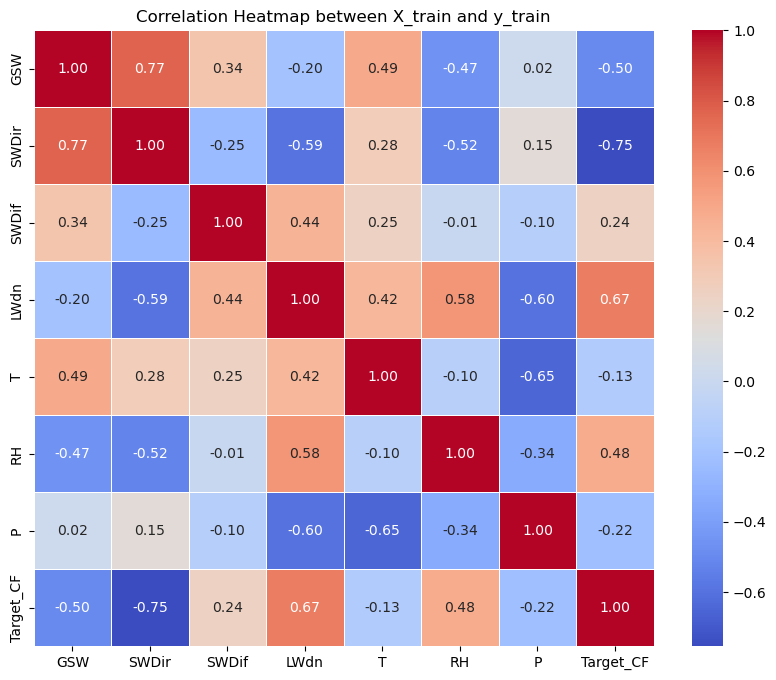

In [5]:

# Combine X_train and y_train into a single DataFrame for correlation calculation
data = pd.concat([X_train, y_train.rename('Target_CF')], axis=1)

# Compute the correlation matrix
correlation_matrix = data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap between X_train and y_train")
plt.show()


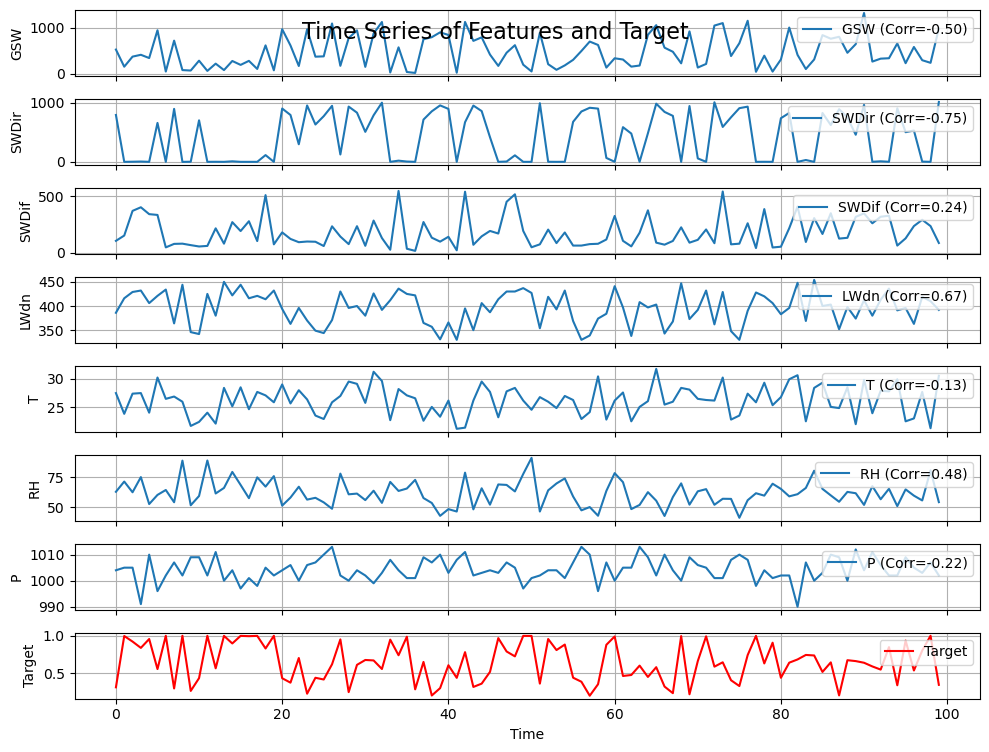

In [6]:
n_point = 100
# Select the first n_point points
X_train_subset = X_train.iloc[:n_point]
y_train_subset = y_train.iloc[:n_point]

# Compute correlations between features and the target
correlations = X_train.corrwith(y_train)

# Set up the plot grid
n_features = X_train_subset.shape[1]
fig, axes = plt.subplots(n_features + 1, 1, figsize=(10, 1 * (n_features + 1)), sharex=True)

# Plot each feature as a separate subplot
time = np.arange(len(X_train_subset))  # Assuming indices represent time
for i, column in enumerate(X_train_subset.columns):
    axes[i].plot(time, X_train_subset[column], label=f"{column} (Corr={correlations[column]:.2f})")
    axes[i].legend(loc="upper right")
    axes[i].set_ylabel(column)
    axes[i].grid()

# Plot the target variable at the bottom
axes[-1].plot(time, y_train_subset, color='red', label='Target')
axes[-1].legend(loc="upper right")
axes[-1].set_ylabel("Target")
axes[-1].grid()

# Set common X-axis label and title
plt.xlabel("Time")
plt.suptitle("Time Series of Features and Target", y=0.92, fontsize=16)
plt.tight_layout()
plt.show()

## 3. Application de l'ACP pour réduire le nombre de caractéristique
L’analyse en composantes principales permet de réduire la dimension du nombre de caractéristique utilisées pour la classification (effectuée sur un nombre réduit de composantes principales). Le nombre de composantes principales utilisées comme caractéristiques dépend du pourcentage de la variance totale expliquée par chaque composante principale.

### 3.1 ACP des données d'entrées

##### (a) Effectuer une ACP des données d'entrées d'apprentissage X_train et  appliquer cette ACP aux  données d'entrées X_test.

On notera X_train_ACP et X_test_ACP les entrées obtenues après l'ACP.

In [7]:
from sklearn.decomposition import PCA

# ACP
model_ACP = PCA()
X_pca_train = model_ACP.fit_transform(X_train)
X_pca_valid = model_ACP.fit_transform(X_valid)
X_pca_test = model_ACP.transform(X_test)

print(X_pca_test.shape, y_test.shape)


(33459, 7) (33459, 1)


##### (b) Visualiser les 2 premières composantes

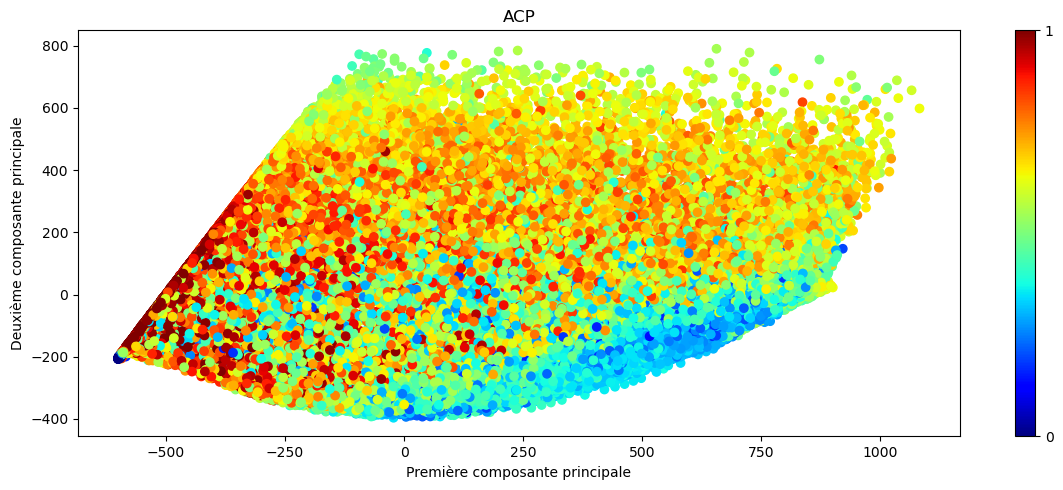

In [8]:
# Visualisation des 2 premières composantes
plt.figure(figsize=(12, 5))


plt.scatter(X_pca_train[:, 0], X_pca_train[:, 1], c=y_train, cmap=plt.colormaps.get_cmap('jet'))
plt.colorbar(ticks=range(10))
plt.title('ACP')
plt.xlabel('Première composante principale')
plt.ylabel('Deuxième composante principale')

plt.tight_layout()
plt.show()

### 3.2 Visualisation du pourcentage de variance expliqué par chaque composante

##### (a) Calculer et visualiser le pourcentage de variance expliquée par chaque composante.

Text(0.5, 1.0, 'Variance expliquée')

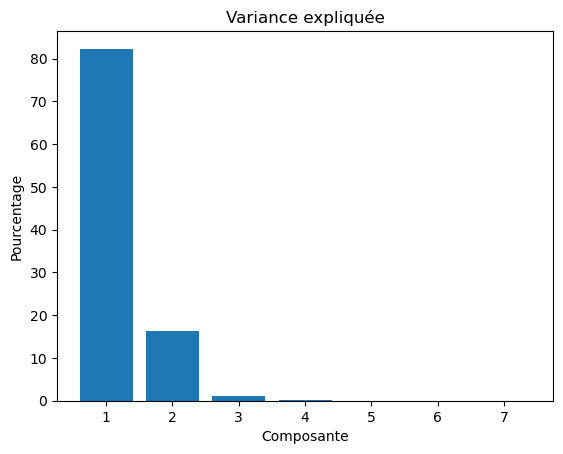

In [9]:
#------------- Calcul du pourcentage de variance expliquée par chaque composante-----------------
variance=model_ACP.explained_variance_ratio_
variance=variance*100

#------------- Visualisation graphique de la variance expliquée par chaque composante-----------------
plt.figure()
plt.bar(range(1,len(variance)+1),variance)  # tracer du graphe
plt.xlabel('Composante')  # titre sur l'axe des abcisses
plt.ylabel('Pourcentage')  # titre sur l'axe des ordonnés
plt.title('Variance expliquée')  # ajout d'un titre


##### (b) Calculer et visualiser le pourcentage de la variance expliquée cumulée.


Pourcentage de variance cumulée est : [ 82.34  98.64  99.82  99.98 100.   100.   100.  ] %


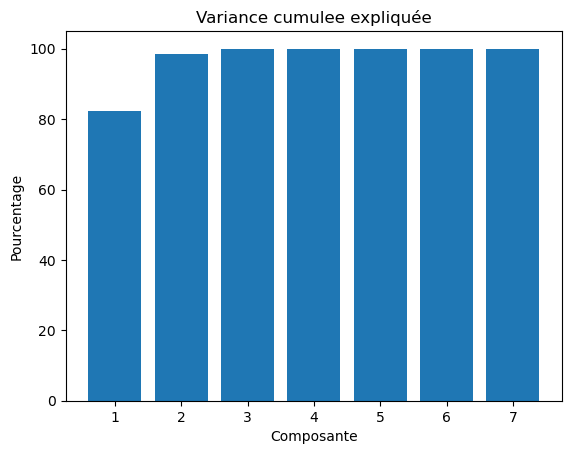

In [10]:
#------------- Calcul de la variance expliquée cumulée-----------------
variance_cumulee = np.cumsum(variance)


#------------- Visualisation graphique de la variance expliquée cumulée -----------------
plt.figure()
plt.bar(range(1,len(variance_cumulee)+1),variance_cumulee) # tracer du graphe
plt.xlabel('Composante')  # titre sur l'axe des abcisses
plt.ylabel('Pourcentage')  # titre sur l'axe des ordonnés
plt.title('Variance cumulee expliquée')  # ajout d'un titre

#------------- Afficher le pourcentage de variance expliquée cumulée (garder 2 chiffres après la virgule)
print('\nPourcentage de variance cumulée est :', variance_cumulee.round(2),'%')

### 3.3 Réduction du nombre de caractéristiques utililisées pour la classification

A partir des résultats précendents, conserver uniquement les composantes nécessaire afin de préserver plus 80% de l'information. On notera X_train_reduit et X_test_reduit les résultats obtenus.

### 3.4 test with different number of feature 

In [11]:
from xgboost import XGBRegressor
model = XGBRegressor(
      learning_rate=0.5, n_estimators=200,
      max_depth=5, min_child_weight=3,
      subsample=0.8, colsample_bytree=0.8,
      reg_alpha=0, reg_lambda=0,
      base_score=0.5, booster='gbtree', importance_type='gain',
      interaction_constraints='', validate_parameters=1, verbosity=None)


In [16]:
# test from 1 to 7 components:
# -----------------------------------------------------------------------

def pca_test(X_pca_train, X_pca_valid, X_pca_test, fig_name='pca_test.png'):

    total_component = X_pca_train.shape[1]

    feature_names = [f'component_{i}' for i in range(1, total_component+1)]

    # initial variables

    mab, rmse, cor, r_squared = [], [], [], []
    validation_accuracies = []
    train_accuracies = []

    print('N of features: ', end='')
    # Iterate by reducing features
    for i in range(1,total_component+1):
        print(f'{i}, ', end='')

        X_train_reduced = X_pca_train[:,:i]
        X_valid_reduced = X_pca_valid[:,:i]
        X_test_reduced = X_pca_test[:,:i]

        # print("reduced:", X_pca_test.shape, y_test.shape, X_test_reduced.shape)

        evalSet = [(X_train_reduced, y_train), (X_valid_reduced, y_valid)]

        # print(f'start training...')
        # print(X_train_reduced.shape, y_train.shape)

        model.fit(X_train_reduced, y_train, verbose=False, eval_set=evalSet)

        scr_train = round(model.score(X_train_reduced, y_train), 4)
        scr_valid = round(model.score(X_valid_reduced, y_valid), 4)

        # plot_learning_curve(model, scr_train, scr_valid, ['pca'], fig_name=f'{X_train_reduced.shape[1]}_features.png')

        y_test['CF_pred'] = model.predict(X_test_reduced)

        stats: dict = RESEARCH.calculate_statistics_y_pred_y_test(y_test)

        train_accuracies.append(scr_train)
        validation_accuracies.append(scr_valid)
        mab.append(stats['MAB'])
        rmse.append(stats['RMSE'])
        cor.append(stats['COR'])
        r_squared.append(stats['R_squared'])

    # ------------------------------ plot
    plt.figure(figsize=(10, 6))
    
    statistics = [mab, rmse, cor, r_squared, train_accuracies, validation_accuracies]
    statistics_labels = ['MAB', 'RMSE', 'COR', 'R_squared (test data)', 'train_score_R^2', 'validation_score_R^2']
    
    x = range(1, total_component + 1)
    
    for i in range(len(statistics)):
        plt.plot(x, statistics[i], label=statistics_labels[i], marker='o')
        plt.xlabel("Number of Features")
        plt.ylabel("Accuracy")
        plt.title("PCA: Model Performance")
        plt.legend()
    
    plt.grid()
    plt.ylim([0, 1])
    
    # Add a text box
    
    model_params = f'default XGBoost model: \n'\
                   f'learning_rate=0.5, n_estimators=200,\n'\
                   f'max_depth=5, min_child_weight=3,\n'\
                   f'subsample=0.8, colsample_bytree=0.8,'
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    
    plt.text(0.45, 0.5, model_params, fontsize=12, color='black', transform=plt.gca().transAxes,
             bbox=props, horizontalalignment='center', verticalalignment='center', wrap=True)
    
    plt.savefig(fig_name, dpi=220)
    plt.show()

N of features: 1, 2, 3, 4, 5, 6, 7, 

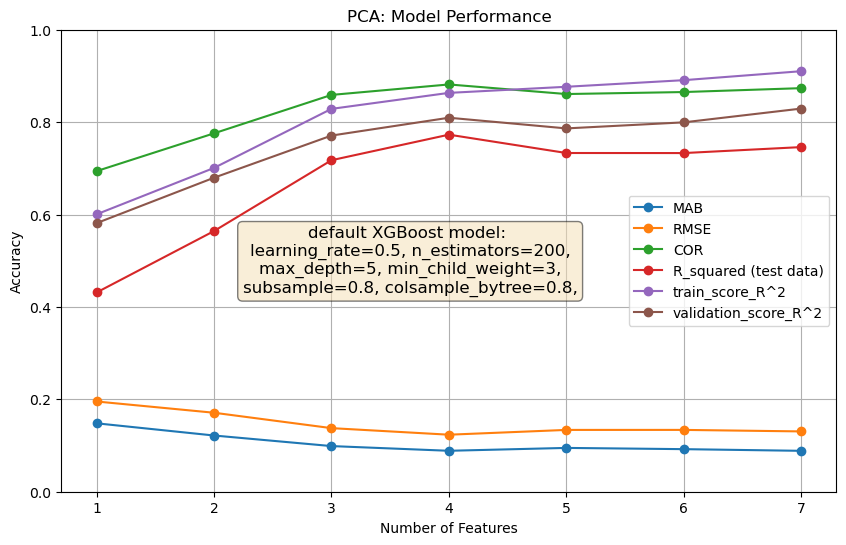

In [17]:
pca_test(X_pca_train=X_pca_train, X_pca_valid=X_pca_valid, X_pca_test=X_pca_test, fig_name='pca_test.png')


## 3BIS. Application de kernel ACP pour réduire le nombre de caractéristique

### 3.1BIS KACP des données d'entrées

kACP des données d'entrées

Déterminer la bibliothèque, les instructions et les structures requises :
- pour effectuer une kACP des données d'entrées d'apprentissage X_train,
- et pour appliquer cette kACP aux  données d'entrées X_test.

On notera X_train_kACP et X_test_kACP les entrées obtenues après l'kACP. **On utilisera un kernel cosine.**

In [ ]:
from sklearn.decomposition import KernelPCA

n_component = 5

# kACP
#On conserve n_component composante comme pour ACP
kernel_pca = KernelPCA(n_components=n_component,kernel="cosine") 

X_kpca_train = kernel_pca.fit_transform(X_train)
X_kpca_test = kernel_pca.transform(X_test)


In [ ]:
# Visualisation des 2 premières composantes
plt.figure(figsize=(12, 5))

plt.scatter(X_kpca_train[:, 0], X_kpca_train[:, 1], c=y_train, cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar(ticks=range(10))
plt.title('kPCA cosine')
plt.xlabel('Première composante principale')
plt.ylabel('Deuxième composante principale')

plt.tight_layout()
plt.show()

In [ ]:
# test kPCA result with XGBoost model:
pca_test(X_pca_train=X_pca_train, X_pca_valid=X_pca_valid, X_pca_test=X_pca_valid, fig_name='pca_test.png')

Remarque : On fait un peu mieux qu'avec ACP mais on a toujours 13 composantes

## 4. Application de UMAP (Uniform manifold approximation and projection for dimension reduction) pour réduire le nombre de caractéristique

### 4.1 UMAP des données d'entrées

Déterminer la bibliothèque, les instructions et les structures requises :
- pour effectuer UMAP des données d'entrées d'apprentissage X_train pour réduire le nombre de caractéristiques à 2,
- et pour appliquer UMAP aux  données d'entrées X_test.

On notera X_train_umap et X_test_umap les entrées obtenues après UMAP.

In [75]:
# UMAP alternative plus récente à t-sne

#INSTALLATION 
# Dans un terminal : 
# !pip install umap-learn

from umap import UMAP

n_component = 4

umap = UMAP(n_components=4, random_state=42, n_jobs=2)
# where n_jobs is for for parallelism, default is 1.

X_umap_train = umap.fit_transform(X_train)
X_umap_valid = umap.transform(X_valid)
X_umap_test = umap.transform(X_test)


/Users/ctang/anaconda3/envs/GEO_24/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


##### (b) Visualiser les 2 premières composantes

/var/folders/5l/kfstrwgj10102hslf3251mmm0000gn/T/ipykernel_57566/4209785125.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(X_umap_train[:, 0], X_umap_train[:, 1], c=y_train, cmap=plt.cm.get_cmap('jet', 10))


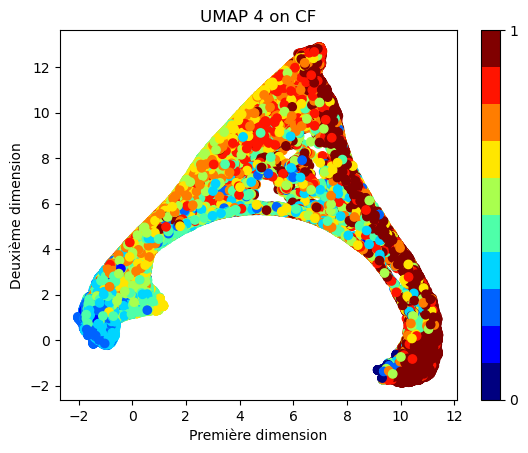

In [77]:
# visulation des 2 premières composantes
plt.scatter(X_umap_train[:, 0], X_umap_train[:, 1], c=y_train, cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar(ticks=range(10))
plt.title(f'UMAP {n_component} on CF')
plt.xlabel('Première dimension')
plt.ylabel('Deuxième dimension')
plt.savefig(f'umap_component_{n_component}.png', dpi=220)

#### Remarque
On observe que UMAP sépare beaucoup mieux les différentes classes qu'avec l'ACP et la kACP.

#### 4.1.1  Identification d'un modèle XGBoost en utilisant  un nombre réduit de caractéristiques
Identifier un modèle KNN à 3 voisins à partir des données d'entrées-sortie d'apprentissage X_train_umap et y_train.

Aanalyser en détail les résultats obtenus en apprentissage et en validation.
Utiliser les **matrices de confusion.**

**Commenter les résultats obtenus**.

reduced: (33459, 4) (33459, 2) (33459, 1)
start training...
(74565, 1) (74565,)


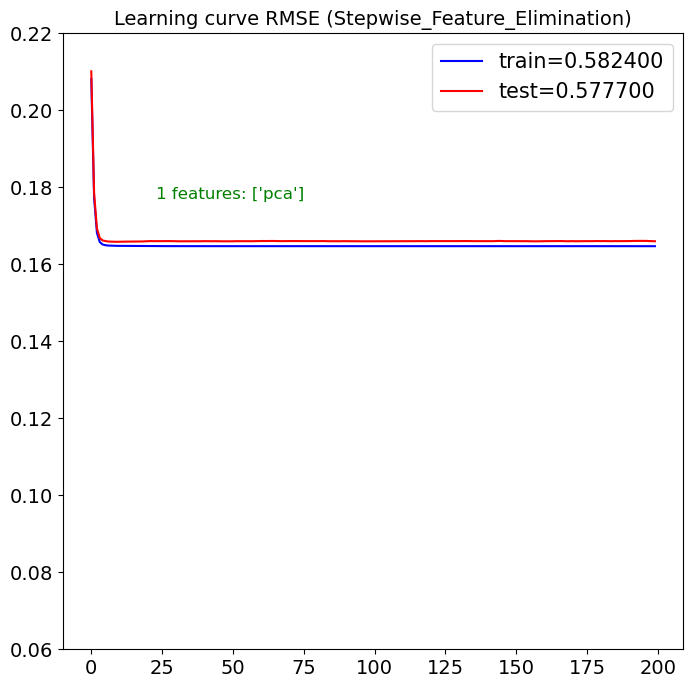


Statistics:
MAB                 :   0.14
RMSE                :   0.19
COR                 :   0.70
R_squared           :   0.45
reduced: (33459, 4) (33459, 2) (33459, 2)
start training...
(74565, 2) (74565,)


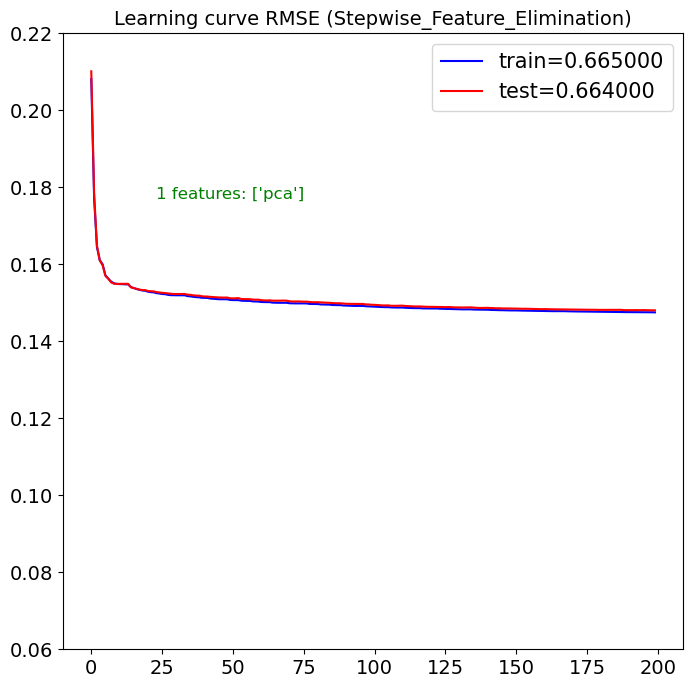


Statistics:
MAB                 :   0.12
RMSE                :   0.17
COR                 :   0.78
R_squared           :   0.58
reduced: (33459, 4) (33459, 2) (33459, 3)
start training...
(74565, 3) (74565,)


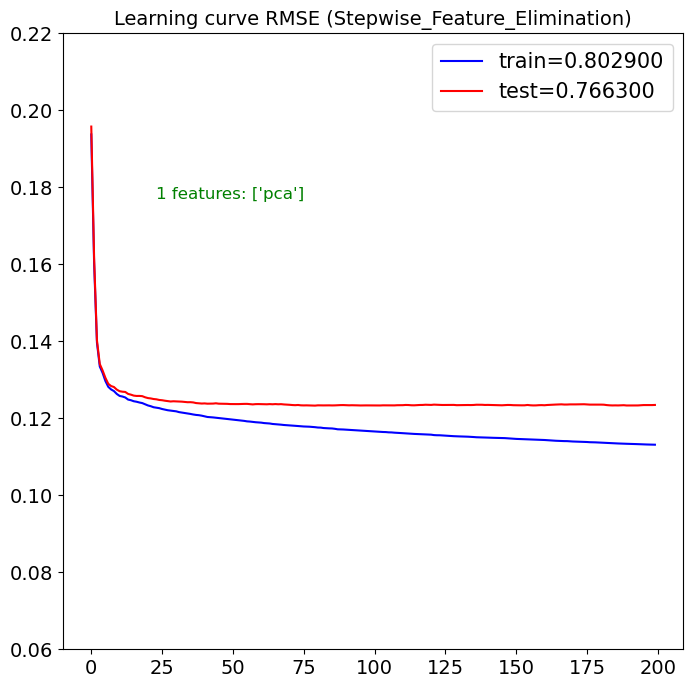


Statistics:
MAB                 :   0.10
RMSE                :   0.14
COR                 :   0.86
R_squared           :   0.73
reduced: (33459, 4) (33459, 2) (33459, 4)
start training...
(74565, 4) (74565,)


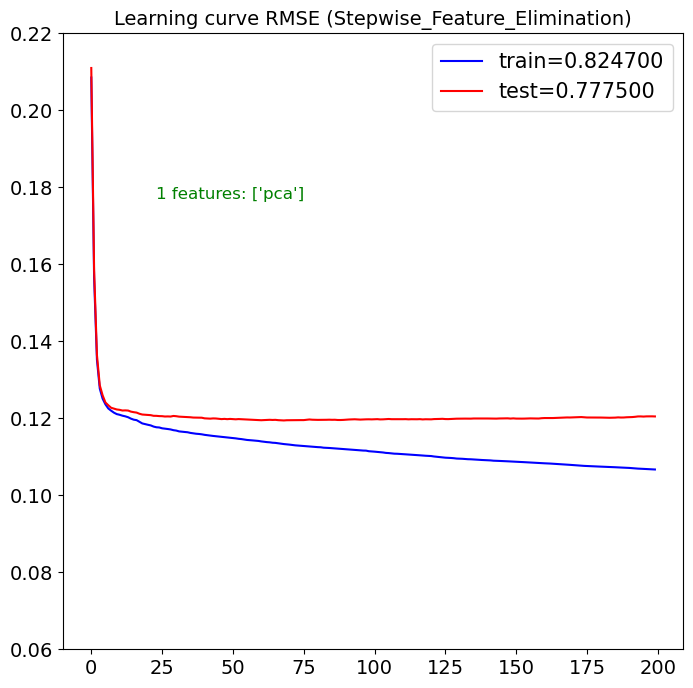


Statistics:
MAB                 :   0.09
RMSE                :   0.13
COR                 :   0.87
R_squared           :   0.74


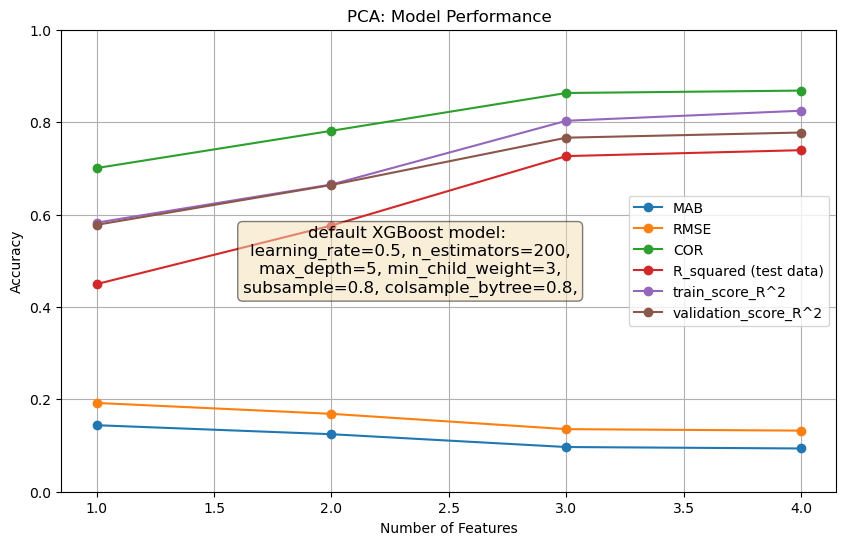

In [73]:
pca_test(X_pca_train=X_umap_train, X_pca_valid=X_umap_valid, X_pca_test=X_umap_test, fig_name='umap_test.png')

### REMARQUE
On obtient des résultats comparables mais avec uniqument 2 composantes au lieu de 13 !!

### REMARQUE
Amélioration des résultats obtenus avec l'ACP avec uniqument 2 composantes au lieu de 13 !!

### 4.5 Commenter les résultats obtenus
... \
...